In [127]:
import somadata
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
import numpy as np
import scipy.stats
import os
from io import StringIO
print("Done")

Done


In [128]:
from scipy.stats import ttest_ind
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from io import StringIO
print('done')

done


In [129]:
#Path to this directory
dirpath = os.path.abspath(os.path.dirname('SAHData.ipynb'))

In [130]:
#adat file that has been plate scaled and hybrid normalized (not median normalized)
adat_path = dirpath + '/Data/UFL-17-005DataFromSoma-Jenna-SerumConbine/UFL-17-005.hybNorm.plateScale.20180411.adat'
adat = somadata.read_adat(adat_path)
type(adat)

/Users/kenny/opt/anaconda3/lib/python3.9/site-packages/somadata/io/adat/file.py:125: UserWarning: V3 style seqIds (i.e., 12345-6_7). Converting to V4 Style. The adat file writer has an option to write using the V3 style
  warnings.warn(


somadata.adat.Adat

In [131]:
#dictionary to be able to retrieve the location of any of these samples in the adat

sample_dict = {}
for i in range(len(adat.index)):
    sample_dict[ adat.index[i][5] ] = i

In [132]:
#Loading in the a CSV. Will need to change path on personal computer
csv_path = dirpath + '/Data/NumbersOnly_vasospasm_identifiers_072224.csv'
df = pd.read_csv(csv_path)
vaso_list = df.iloc[:, 0].tolist()
print(vaso_list)

['1', 'EXCLUDE', '??????Exclude?????? - need to compare, see notes', 'Pilot Control', 'EXCLUDE', '1', '0', '0', 'EXCLUDE', 'EXCLUDE', '1', 'Pilot Control', 'EXCLUDE', 'BB Control', '1', '1', '1', 'BB Control', '0', '1', 'EXCLUDE', '1', '0', '0', 'EXCLUDE', 'BB Control', '1', '1', 'EXCLUDE', '0', 'Pilot Control', '1', '1', '0', '1', '1', '0', '0', '1', 'Pilot Control', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '0', '0', 'Pilot Control', '0', '0', '0', 'Pilot Control', '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0']


In [133]:
#Merging vasospasm data with SAH adat file. Source code derived from Soma Logic Canopy GitHub

vaso_adat = adat.insert_meta(0,'Vasospasm (0=n, 1=y)', vaso_list)
# this will produce a new Adat file with group data in the right most column of the index

vaso_adat.index.to_frame(index=False).loc[0:1]

,PlateId,ScannerID,PlatePosition,SlideId,Subarray,SampleId,SampleType,PercentDilution,SampleMatrix,Barcode,...,AssayNotes,TimePoint,ExtIdentifier,SsfExtId,SampleGroup,SiteId,TubeUniqueID,HybControlNormScale,RowCheck,"Vasospasm (0=n, 1=y)"
0,Set 003,US83800208,H4,257711020969,8,160384,QC,40,QC,160384C,...,QC,,EXID40000001310062,2577110209698,,,,1.125,PASS,1
1,Set 003,US83800208,H3,257711020968,8,PHE-L Dichot,Sample,40,,,...,PHE-L Dichot,,EXID40000001310064,EID323094,,,,0.997,PASS,EXCLUDE


In [134]:
#Displaying adat file. Source code derived from Soma Logic Canopy GitHub

from IPython.display import HTML
#Display the first five rows and columns of the adat
HTML(vaso_adat.iloc[:160, :10].to_html())


,,,,,,,,,,,,,,,,,,,,,,SeqId,10336-3,10337-83,10339-48,10342-55,10344-334,10346-5,10351-51,10356-21,10358-33,10361-25
,,,,,,,,,,,,,,,,,,,,,,SeqIdVersion,3,3,3,3,3,3,3,3,3,3
,,,,,,,,,,,,,,,,,,,,,,SomaId,SL019100,SL007136,SL001731,SL019096,SL005173,SL007221,SL007108,SL000455,SL003755,SL014684
,,,,,,,,,,,,,,,,,,,,,,TargetFullName,E3 ubiquitin-protein ligase CHIP,CCAAT/enhancer-binding protein beta,Gamma-enolase,E3 SUMO-protein ligase PIAS4,Interleukin-10 receptor subunit alpha,Signal transducer and activator of transcription 3,Interferon regulatory factor 1,Transcription factor AP-1,Induced myeloid leukemia cell differentiation protein Mcl-1,2'-5'-oligoadenylate synthase 1
,,,,,,,,,,,,,,,,,,,,,,Target,CHIP,CEBPB,NSE,PIAS4,IL-10 Ra,STAT3,IRF1,c-Jun,Mcl-1,OAS1
,,,,,,,,,,,,,,,,,,,,,,UniProt,Q9UNE7,P17676,P09104,Q8N2W9,Q13651,P40763,P10914,P05412,Q07820,P00973
,,,,,,,,,,,,,,,,,,,,,,EntrezGeneID,10273,1051,2026,51588,3587,6774,3659,3725,4170,4938
,,,,,,,,,,,,,,,,,,,,,,EntrezGeneSymbol,STUB1,CEBPB,ENO2,PIAS4,IL10RA,STAT3,IRF1,JUN,MCL1,OAS1
,,,,,,,,,,,,,,,,,,,,,,Organism,Human,Human,Human,Human,Human,Human,Human,Human,Human,Human
,,,,,,,,,,,,,,,,,,,,,,Units,RFU,RFU,RFU,RFU,RFU,RFU,RFU,RFU,RFU,RFU
,,,,,,,,,,,,,,,,,,,,,,Type,Protein,Protein,Protein,Protein,Protein,Protein,Protein,Protein,Protein,Protein


In [135]:
#Check to see number of patients vs controls/calibrators
Counter(vaso_adat.index.get_level_values('SampleType'))

Counter({'QC': 9, 'Sample': 72, 'Calibrator': 15})

##Testing to see if line 55 and 58 for master sheet were identical patients:

In [136]:
RedudantQC_filtered_transformed_data = (
    vaso_adat
        .exclude_on_meta(axis=0, name='SampleMatrix', values=['Calibrator', 'QC'])                     
        .pick_on_meta(axis=0, name='SampleId', values=['S-01-120710', '184277'])  # rm control samples
        #.apply(np.log10)                                             # log10-transform
)
RedudantQC_filtered_transformed_data
##The two patients have different protein levels

,,,,,,,,,,,,,,,,,,,,,,SeqId,10336-3,10337-83,10339-48,10342-55,10344-334,10346-5,10351-51,10356-21,10358-33,10361-25,...,9199-6,9201-13,9202-309,9204-33,9207-60,9211-19,9212-22,9213-24,9215-117,9216-100
,,,,,,,,,,,,,,,,,,,,,,SeqIdVersion,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
,,,,,,,,,,,,,,,,,,,,,,SomaId,SL019100,SL007136,SL001731,SL019096,SL005173,SL007221,SL007108,SL000455,SL003755,SL014684,...,SL018946,SL004811,SL008113,SL009210,SL018887,SL003066,SL008381,SL018900,SL018947,SL009948
,,,,,,,,,,,,,,,,,,,,,,TargetFullName,E3 ubiquitin-protein ligase CHIP,CCAAT/enhancer-binding protein beta,Gamma-enolase,E3 SUMO-protein ligase PIAS4,Interleukin-10 receptor subunit alpha,Signal transducer and activator of transcription 3,Interferon regulatory factor 1,Transcription factor AP-1,Induced myeloid leukemia cell differentiation protein Mcl-1,2'-5'-oligoadenylate synthase 1,...,Ubiquitin-conjugating enzyme E2 G2,Transgelin-2,"ATP synthase subunit O, mitochondrial",Pro-opiomelanocortin,Quinone oxidoreductase-like protein 1,Pigment epithelium-derived factor,Cathepsin F,Formimidoyltransferase-cyclodeaminase,Ubiquitin carboxyl-terminal hydrolase 25,Plexin-B2
,,,,,,,,,,,,,,,,,,,,,,Target,CHIP,CEBPB,NSE,PIAS4,IL-10 Ra,STAT3,IRF1,c-Jun,Mcl-1,OAS1,...,UB2G2,Transgelin-2,ATPO,Corticotropin-lipotropin,QORL1,PEDF,CATF,FTCD,UBP25,PLXB2
,,,,,,,,,,,,,,,,,,,,,,UniProt,Q9UNE7,P17676,P09104,Q8N2W9,Q13651,P40763,P10914,P05412,Q07820,P00973,...,P60604,P37802,P48047,P01189,O95825,P36955,Q9UBX1,O95954,Q9UHP3,O15031
,,,,,,,,,,,,,,,,,,,,,,EntrezGeneID,10273,1051,2026,51588,3587,6774,3659,3725,4170,4938,...,7327,8407,539,5443,9946,5176,8722,10841,29761,23654
,,,,,,,,,,,,,,,,,,,,,,EntrezGeneSymbol,STUB1,CEBPB,ENO2,PIAS4,IL10RA,STAT3,IRF1,JUN,MCL1,OAS1,...,UBE2G2,TAGLN2,ATP5O,POMC,CRYZL1,SERPINF1,CTSF,FTCD,USP25,PLXNB2
,,,,,,,,,,,,,,,,,,,,,,Organism,Human,Human,Human,Human,Human,Human,Human,Human,Human,Human,...,Human,Human,Human,Human,Human,Human,Human,Human,Human,Human
,,,,,,,,,,,,,,,,,,,,,,Units,RFU,RFU,RFU,RFU,RFU,RFU,RFU,RFU,RFU,RFU,...,RFU,RFU,RFU,RFU,RFU,RFU,RFU,RFU,RFU,RFU
,,,,,,,,,,,,,,,,,,,,,,Type,Protein,Protein,Protein,Protein,Protein,Protein,Protein,Protein,Protein,Protein,...,Protein,Protein,Protein,Protein,Protein,Protein,Protein,Protein,Protein,Protein


##Testing to see how different Control b and BB controls are from eachother

In [137]:
control_check = (
    vaso_adat
        .exclude_on_meta(axis=0, name='SampleMatrix', values=['Calibrator', 'QC'])                     
        .pick_on_meta(axis=0, name='Vasospasm (0=n, 1=y)', values=['Pilot Control', 'BB Control'])  # rm control samples
        .apply(np.log10)                                             # log10-transform
)

In [138]:
clean_control_check = (
    control_check
        .insert_keyed_meta(                                          
            axis=0,
            key_meta_name='Vasospasm (0=n, 1=y)',
            inserted_meta_name='Control',
            values_dict={'Pilot Control': 1, 'BB Control': 0}
        )
        .apply(lambda x: x - x.mean(), axis=0)                       # center features
        .apply(lambda x: x / x.std(), axis=0)                        # scale features
)

In [139]:
tt_BB = clean_control_check.pick_on_meta(axis=0, name='Control', values=[0])
tt_Pilot = clean_control_check.pick_on_meta(axis=0, name='Control', values=[1])

tt_res_control = ttest_ind(tt_BB, tt_Pilot)
t_tests_control = list(zip(clean_control_check.columns.get_level_values('TargetFullName'), tt_res_control.pvalue))
len(t_tests_control) #1317

significant_tests_control = [item for item in t_tests_control if item[1] < 0.05]
len(significant_tests_control) #162
#Only 162/1317 analytes were statistically different between the control groups

675

In [140]:
t_tests_control_sorted = sorted(significant_tests_control, key=lambda x: x[1])
tt_top_12_analytes = [name for name, p_value in t_tests_control_sorted[:12]]
tt_top_12_analytes
print("p values of top 12: ", t_tests_control_sorted[:12])

p values of top 12:  [('Epidermal growth factor receptor variant III', 2.1329003440275722e-05), ('Protein kinase C delta type', 3.0372123554197848e-05), ('PIK3CA/PIK3R1', 3.3581671914792234e-05), ('Glyceraldehyde-3-phosphate dehydrogenase', 6.873335094464886e-05), ('3-hydroxyacyl-CoA dehydrogenase type-2', 0.00014894787177924297), ('NADPH--cytochrome P450 reductase', 0.00015992217084049383), ('High affinity nerve growth factor receptor', 0.00018660387620186446), ('Kynureninase', 0.00018996871871205015), ('Syntaxin-1A', 0.0002042952981697294), ('N-terminal pro-BNP', 0.00024924477983353637), ('Aurora kinase A', 0.0002506275251944812), ('Protein kinase C alpha type', 0.00028052265068922403)]


##Red Cell Check:

In [141]:
redCell_dict = {'S-1-020507': 1, 'S-1-111708': 1, 'S-1-041405': 1, 'S-1-070607': 1}

redCell_list = ['0'] * 96
redCell_list[sample_dict['135203']] = '1'
redCell_list[sample_dict['158020']] = '1'
redCell_list[sample_dict['116636']] = '1'
redCell_list[sample_dict['141852']] = '1'

In [142]:
#Merging vasospasm data with SAH adat file. Source code derived from Soma Logic Canopy GitHub

redCell_adat = vaso_adat.insert_meta(0,'redCell', redCell_list)
# this will produce a new Adat file with group data in the right most column of the index

#HTML(redCell_adat.iloc[:160, :10].to_html())

In [143]:
redCell_check = (
    redCell_adat
        .exclude_on_meta(axis=0, name='SampleMatrix', values=['Calibrator', 'QC'])                     
        .pick_on_meta(axis=0, name='redCell', values=['0','1'])  # rm control samples
        .apply(np.log10)                                             # log10-transform
)

#proteins without log10 transformation
adat_10336_3 = (
    vaso_adat.pick_on_meta(axis=1, name='SeqId', values=['10336-3'])                     
)
adat_10337_83 = (
    vaso_adat.pick_on_meta(axis=1, name='SeqId', values=['10337-83'])                     
)
adat_10339_48 = (
    vaso_adat.pick_on_meta(axis=1, name='SeqId', values=['10339-48'])                     
)

#proteins with log10 transformation
adat_10336_3_10 = (
    vaso_adat.pick_on_meta(axis=1, name='SeqId', values=['10336-3'])
    .apply(np.log10)
)
adat_10337_83_10 = (
    vaso_adat.pick_on_meta(axis=1, name='SeqId', values=['10337-83'])
    .apply(np.log10)
)
adat_10339_48_10 = (
    vaso_adat.pick_on_meta(axis=1, name='SeqId', values=['10339-48'])
    .apply(np.log10)
)

In [144]:
#E3 ubiquitin-protein ligase CHIP
data = scipy.stats.norm.rvs(size=100000, loc=0, scale=1.5,random_state=123)
hist = np.histogram(adat_10336_3, bins=[1,100,200,300,400,500,600,700,800])
hist

(array([ 0,  4, 30, 16, 10,  5,  7,  4]),
 array([  1, 100, 200, 300, 400, 500, 600, 700, 800]))

In [145]:
#E3 ubiquitin-protein ligase CHIP WITH log(10)
data = scipy.stats.norm.rvs(size=100000, loc=0, scale=1.5,random_state=123)
hist = np.histogram(adat_10336_3_10, bins=8)
hist

(array([15, 34, 18, 16,  7,  1,  2,  3]),
 array([2.17493159, 2.38396698, 2.59300237, 2.80203776, 3.01107315,
        3.22010854, 3.42914393, 3.63817932, 3.84721471]))

In [146]:
#CCAAT/enhancer-binding protein beta
data2 = scipy.stats.norm.rvs(size=100000, loc=0, scale=1.5,random_state=123)
hist2 = np.histogram(adat_10337_83, bins=[1,400,800,1200,1600,2000,2400,2800])
hist2

(array([ 2, 35, 38, 11,  5,  4,  0]),
 array([   1,  400,  800, 1200, 1600, 2000, 2400, 2800]))

In [147]:
#CCAAT/enhancer-binding protein beta WITH log(10)
data2 = scipy.stats.norm.rvs(size=100000, loc=0, scale=1.5,random_state=123)
hist2 = np.histogram(adat_10337_83_10, bins=8)
hist2

(array([ 5, 35, 42, 11,  2,  0,  0,  1]),
 array([2.49665294, 2.70698692, 2.91732091, 3.12765489, 3.33798888,
        3.54832286, 3.75865685, 3.96899083, 4.17932482]))

In [148]:
#Gamma-enolase
data3 = scipy.stats.norm.rvs(size=100000, loc=0, scale=1.5,random_state=123)
hist3 = np.histogram(adat_10339_48, bins=[1,200,400,600,800,1000,1200,1400])
hist3

(array([19, 14,  5,  8, 14,  4,  2]),
 array([   1,  200,  400,  600,  800, 1000, 1200, 1400]))

In [149]:
#Gamma-enolase
data3 = scipy.stats.norm.rvs(size=100000, loc=0, scale=1.5,random_state=123)
hist3 = np.histogram(adat_10339_48_10, bins=8)
hist3

(array([17, 14, 12, 27, 18,  5,  2,  1]),
 array([1.97497199, 2.27463899, 2.57430599, 2.87397299, 3.17363999,
        3.47330699, 3.77297399, 4.07264099, 4.37230799]))

/var/folders/83/bc6z087n5ng0fvpj2pbn7zy00000gn/T/ipykernel_68176/1997317959.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/83/bc6z087n5ng0fvpj2pbn7zy00000gn/T/ipykernel_68176/1997317959.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
/var/folders/83/bc6z087n5ng0fvpj2pbn7zy00000gn/T/ipykernel_68176/1997317959.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


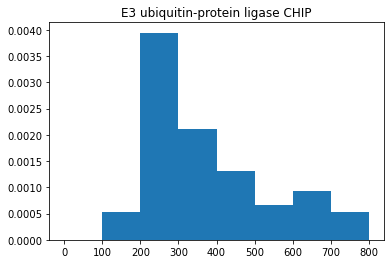

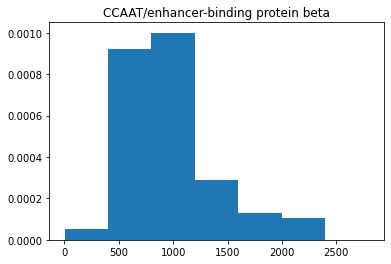

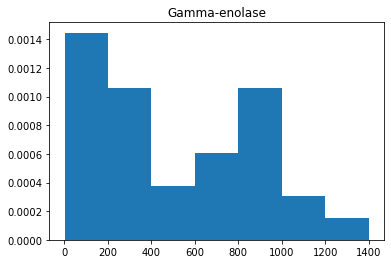

In [150]:
import matplotlib.pyplot as plt
X = np.linspace(-5.0, 5.0, 100)
fig, ax = plt.subplots()
ax.set_title("E3 ubiquitin-protein ligase CHIP")
ax.hist(adat_10336_3, density=True, bins=[1,100,200,300,400,500,600,700,800])


fig2, ax2 = plt.subplots()
ax2.set_title("CCAAT/enhancer-binding protein beta")
ax2.hist(adat_10337_83, density=True, bins=[1,400,800,1200,1600,2000,2400,2800])

fig3, ax3 = plt.subplots()
ax3.set_title("Gamma-enolase")
ax3.hist(adat_10339_48, density=True, bins=[1,200,400,600,800,1000,1200,1400])

fig.show()
fig2.show()
fig3.show()

/var/folders/83/bc6z087n5ng0fvpj2pbn7zy00000gn/T/ipykernel_68176/1735263437.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/83/bc6z087n5ng0fvpj2pbn7zy00000gn/T/ipykernel_68176/1735263437.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
/var/folders/83/bc6z087n5ng0fvpj2pbn7zy00000gn/T/ipykernel_68176/1735263437.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


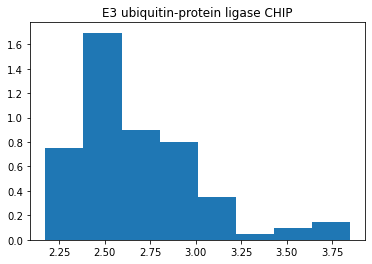

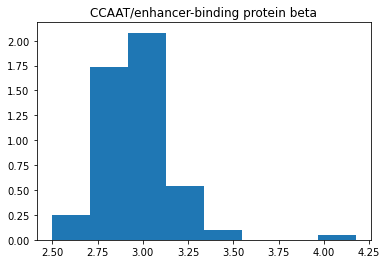

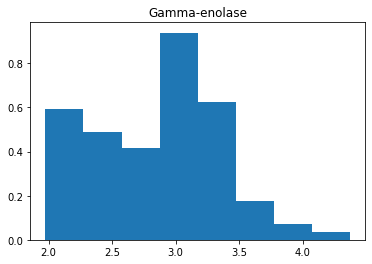

In [151]:
import matplotlib.pyplot as plt
X = np.linspace(-5.0, 5.0, 100)
fig, ax = plt.subplots()
ax.set_title("E3 ubiquitin-protein ligase CHIP")
ax.hist(adat_10336_3_10, density=True, bins=8)

fig2, ax2 = plt.subplots()
ax2.set_title("CCAAT/enhancer-binding protein beta")
ax2.hist(adat_10337_83_10, density=True, bins=8)

fig3, ax3 = plt.subplots()
ax3.set_title("Gamma-enolase")
ax3.hist(adat_10339_48_10, density=True, bins=8)

fig.show()
fig2.show()
fig3.show()

In [152]:
clean_redCell_check = (
    redCell_check
        .insert_keyed_meta(                                          
            axis=0,
            key_meta_name='redCell',
            inserted_meta_name='red',
            values_dict={'1': 1, '0': 0}
        )
        .apply(lambda x: x - x.mean(), axis=0)                       # center features
        .apply(lambda x: x / x.std(), axis=0)                        # scale features
)

In [153]:
tt_sample = clean_redCell_check.pick_on_meta(axis=0, name='red', values=[0])
tt_red_cell = clean_redCell_check.pick_on_meta(axis=0, name='red', values=[1])

tt_res_redCell = ttest_ind(tt_sample, tt_red_cell)
t_tests_redCell = list(zip(clean_redCell_check.columns.get_level_values('TargetFullName'), tt_res_redCell.pvalue))

len(t_tests_redCell) #1317

significant_tests_control = [item for item in t_tests_redCell if item[1] < 0.05]
len(significant_tests_control) #162
#Only 162/1317 analytes were statistically different between the control groups

11

##Below Is beginning of statistical analysis for data:

##Vasospasm vs no Vasospasm - Raw RFU

In [197]:
filtered_transformed_data = (
    redCell_adat
        .exclude_on_meta(axis=0, name='SampleMatrix', values=['Calibrator', 'QC'])                     
          # rm control samples
                                                     # log10-transform
)

filtered_transformed_data = (
    redCell_adat
        .exclude_on_meta(axis=0, name='redCell', values=['1'])                                         # log10-transform
        .pick_on_meta(axis=0, name='Vasospasm (0=n, 1=y)', values=['0', '1'])
        #.apply(np.log10)
)
#HTML(filtered_transformed_data.iloc[:160, :1500].to_html())

In [198]:
clean_data = (
    filtered_transformed_data
        .insert_keyed_meta(                                          
            axis=0,
            key_meta_name='Vasospasm (0=n, 1=y)',
            inserted_meta_name='Vaso',
            values_dict={'1': 1, '0': 0}
        )
        #.apply(lambda x: x - x.mean(), axis=0)                       # center features
        #.apply(lambda x: x / x.std(), axis=0)                        # scale features
)


In [199]:
print(clean_data.index.to_frame()['Vaso'].value_counts())

1    38
0    36
Name: Vaso, dtype: int64


In [200]:
tt_g0 = clean_data.pick_on_meta(axis=0, name='Vaso', values=[0])
tt_g1 = clean_data.pick_on_meta(axis=0, name='Vaso', values=[1])
print(type(tt_g0))

change = tt_g0.sub(tt_g1).div(tt_g1)
tt_res = ttest_ind(tt_g0, tt_g1)
t_tests = list(zip(clean_data.columns.get_level_values('TargetFullName'), tt_res.pvalue))
change_list = list(zip(clean_data.columns.get_level_values('TargetFullName'), change))
change_sorted = sorted(change_list, key=lambda x: x[1])
print(change_sorted)

<class 'somadata.adat.Adat'>
[('E3 ubiquitin-protein ligase CHIP', ('10336-3', '3', 'SL019100', 'E3 ubiquitin-protein ligase CHIP', 'CHIP', 'Q9UNE7', '10273', 'STUB1', 'Human', 'RFU', 'Protein', '40', '1708.5')), ('CCAAT/enhancer-binding protein beta', ('10337-83', '3', 'SL007136', 'CCAAT/enhancer-binding protein beta', 'CEBPB', 'P17676', '1051', 'CEBPB', 'Human', 'RFU', 'Protein', '40', '1788.75')), ('Gamma-enolase', ('10339-48', '3', 'SL001731', 'Gamma-enolase', 'NSE', 'P09104', '2026', 'ENO2', 'Human', 'RFU', 'Protein', '1', '760.6')), ('E3 SUMO-protein ligase PIAS4', ('10342-55', '3', 'SL019096', 'E3 SUMO-protein ligase PIAS4', 'PIAS4', 'Q8N2W9', '51588', 'PIAS4', 'Human', 'RFU', 'Protein', '40', '1125.85')), ('Interleukin-10 receptor subunit alpha', ('10344-334', '3', 'SL005173', 'Interleukin-10 receptor subunit alpha', 'IL-10 Ra', 'Q13651', '3587', 'IL10RA', 'Human', 'RFU', 'Protein', '1', '2464.6')), ('Signal transducer and activator of transcription 3', ('10346-5', '3', 'SL0072

In [201]:
#Distribution
vaso0_mean_hist = np.histogram(tt_g0, bins=8)
vaso0_mean_hist

(array([46407,   572,   220,   114,    58,    38,     2,     1]),
 array([4.20000000e+00, 5.95573875e+04, 1.19110575e+05, 1.78663763e+05,
        2.38216950e+05, 2.97770138e+05, 3.57323325e+05, 4.16876513e+05,
        4.76429700e+05]))

In [202]:
g0_mean = np.mean(tt_g0)
g1_mean = np.mean(tt_g1)
fold_change = np.log2(g1_mean / g0_mean)

data5 = scipy.stats.norm.rvs(size=100000, loc=0, scale=1.5,random_state=123)
hist5 = np.histogram(fold_change, bins=8)
hist5

#change = tt_g0.sub(tt_g1).div(tt_g1)

#change_list = list(zip(clean_data.columns.get_level_values('TargetFullName'), change))
#change_sorted = sorted(change_list, key=lambda x: x[1])

/Users/kenny/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(array([  3,   7, 167, 460, 542, 119,  16,   3]),
 array([-2.16710859, -1.54385609, -0.92060359, -0.29735109,  0.32590141,
         0.94915392,  1.57240642,  2.19565892,  2.81891142]))

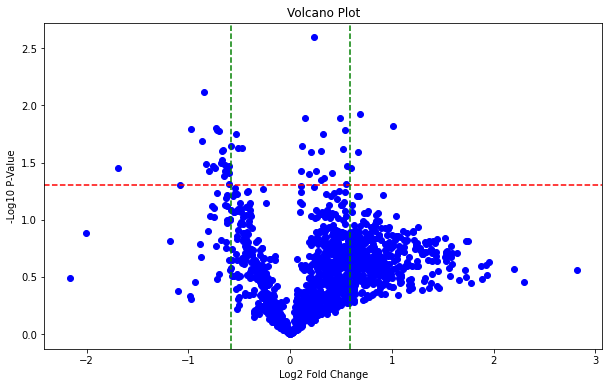

In [203]:
plt.figure(figsize=(10, 6))
plt.scatter(fold_change, np.negative(np.log10(tt_res.pvalue)), color='blue')

# Add horizontal line for p-value significance threshold (e.g., 0.05)
significance_threshold = 0.05
plt.axhline(-np.log10(significance_threshold), color='red', linestyle='--')

# Add vertical lines for fold change cutoffs (e.g., log2(1.5) ~ 0.585)
fold_change_threshold = 1.5
plt.axvline(np.log2(fold_change_threshold), color='green', linestyle='--')
plt.axvline(-np.log2(fold_change_threshold), color='green', linestyle='--')

# Labels and title
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-Value')
plt.title('Volcano Plot')

plt.show()
#plt.scatter(fold_change, tt_res.pvalue, color='blue')

In [204]:
fold_list = list(zip(clean_data.columns.get_level_values('TargetFullName'), fold_change))
fold_change_sorted = sorted(fold_list, key=lambda x: x[1])

upReg_20 = [name for name, down_change in fold_change_sorted[1297:1317]]
downReg_20 = [name for name, down_change in fold_change_sorted[:20]]
downReg_20

['Interleukin-17F',
 'Protein-glutamine gamma-glutamyltransferase E',
 'Serum amyloid A-1 protein',
 'Creatine kinase M-type:Creatine kinase B-type heterodimer',
 'Thymidylate synthase',
 'Carbonic anhydrase 3',
 'Tyrosine-protein phosphatase non-receptor type 1',
 'Olfactomedin-4',
 'C5a anaphylatoxin',
 'Cytotoxic T-lymphocyte protein 4',
 'Complement C4b',
 'Protein Z-dependent protease inhibitor',
 'C-reactive protein',
 'Proprotein convertase subtilisin/kexin type 9',
 'Fibrinogen',
 'Adenylate kinase isoenzyme 1',
 'Myeloblastin',
 'Coagulation Factor XI',
 'Carbonic anhydrase 1',
 'Hemopexin']

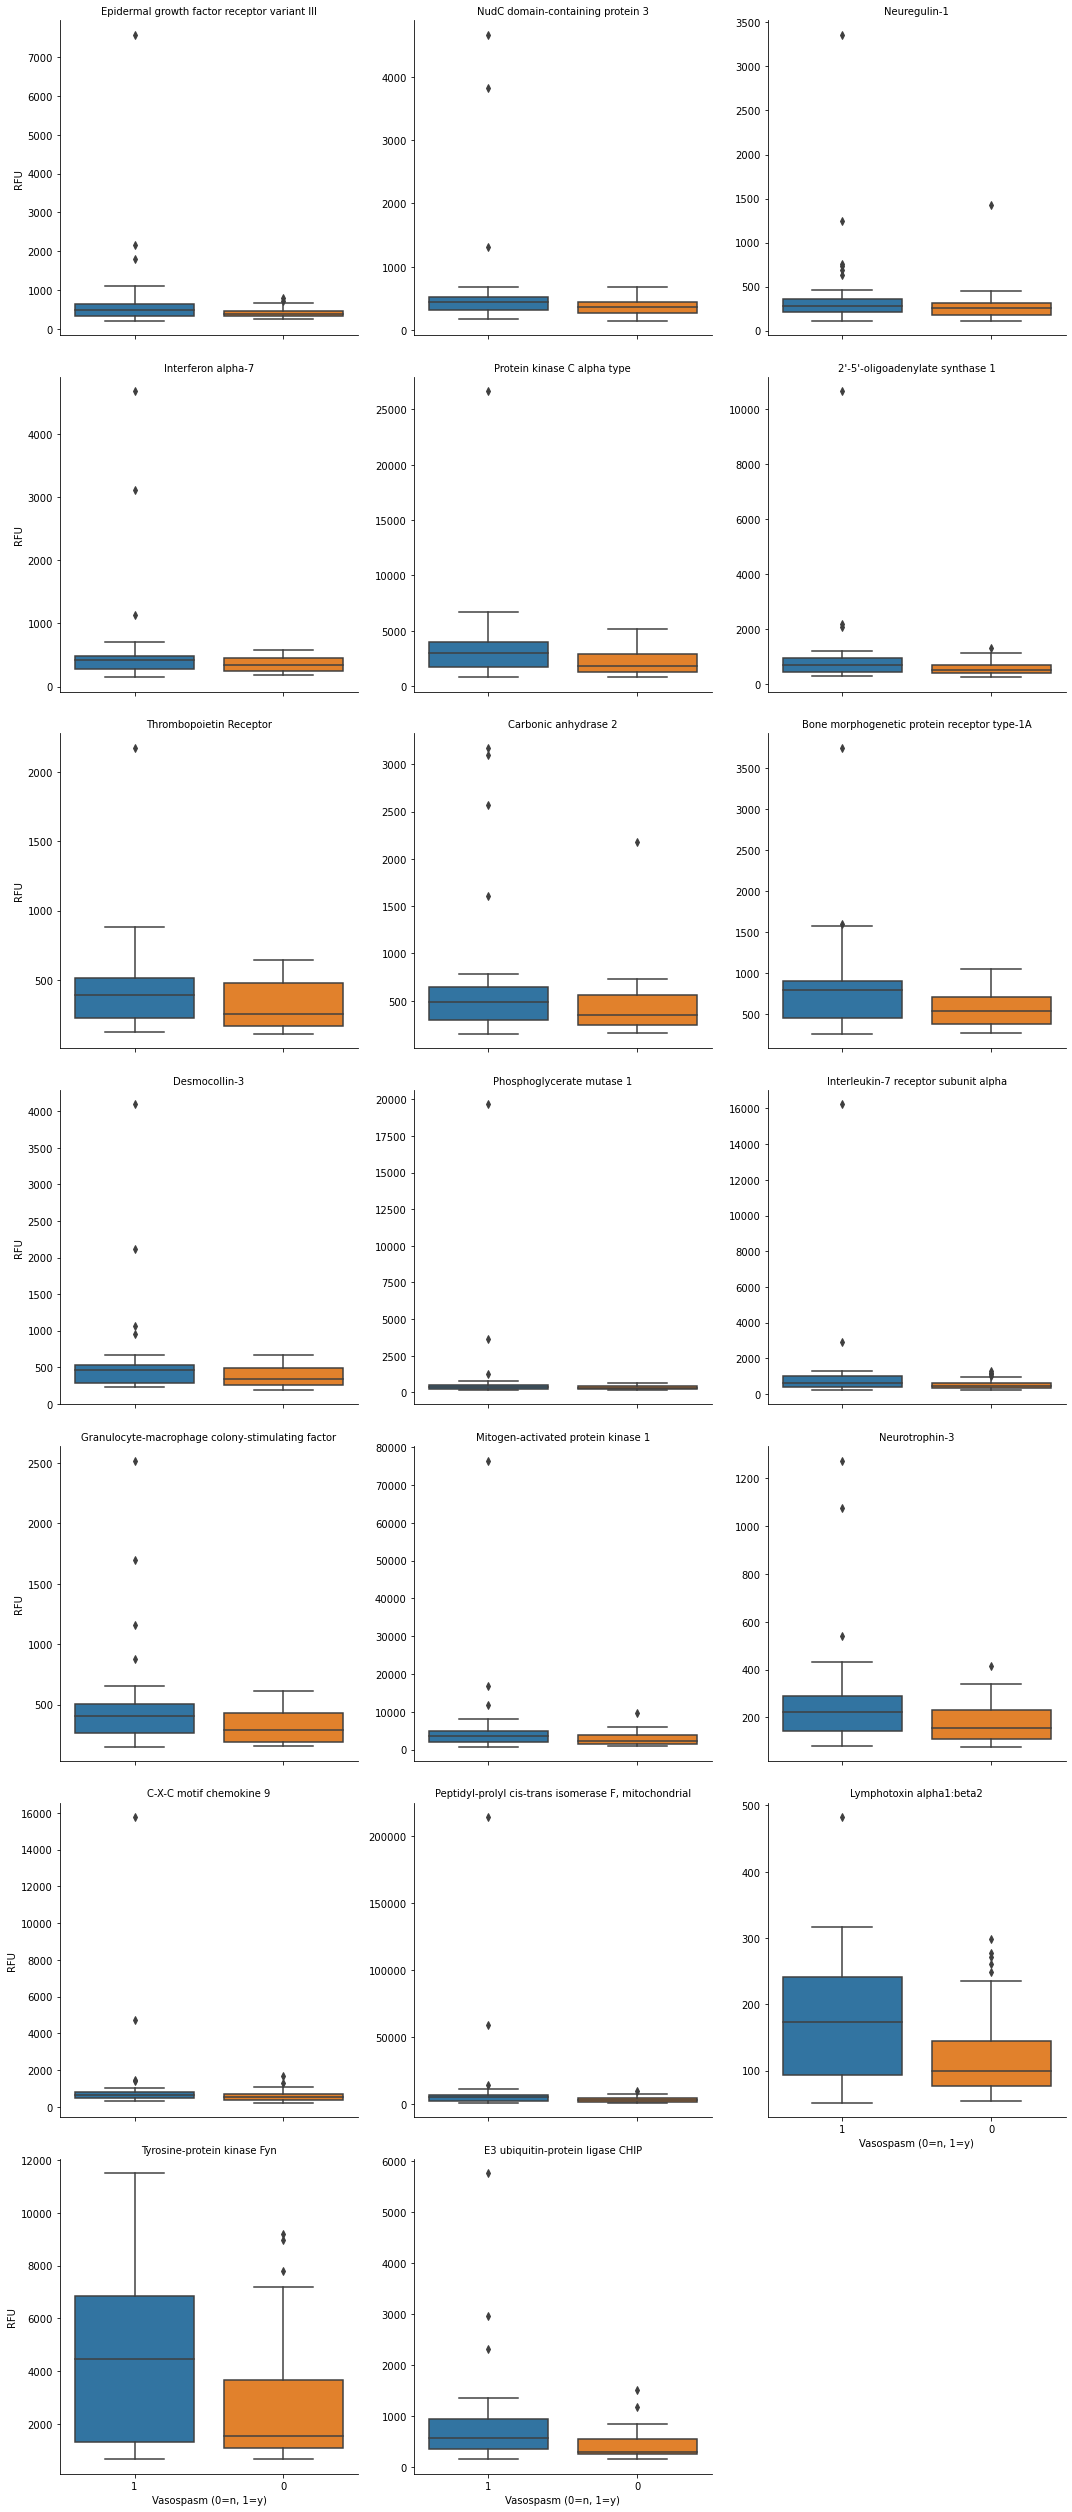

In [205]:
upReg_df = (
    filtered_transformed_data
        .pick_meta(axis=1, names=['TargetFullName'])
        .pick_on_meta(axis=1, name='TargetFullName', values=upReg_20)[upReg_20]
        .reset_index()
)


melted_upReg_df = pd.melt(upReg_df, value_vars=upReg_20, id_vars='Vasospasm (0=n, 1=y)', value_name='RFU')

upReg_p = sns.catplot(
    x='Vasospasm (0=n, 1=y)',
    y='RFU',
    col='TargetFullName',
    data=melted_upReg_df,
    kind='box',
    col_wrap=3,
    sharey=False
)
upReg_p.set_titles(row_template='{row_name}', col_template='{col_name}')
plt.show()

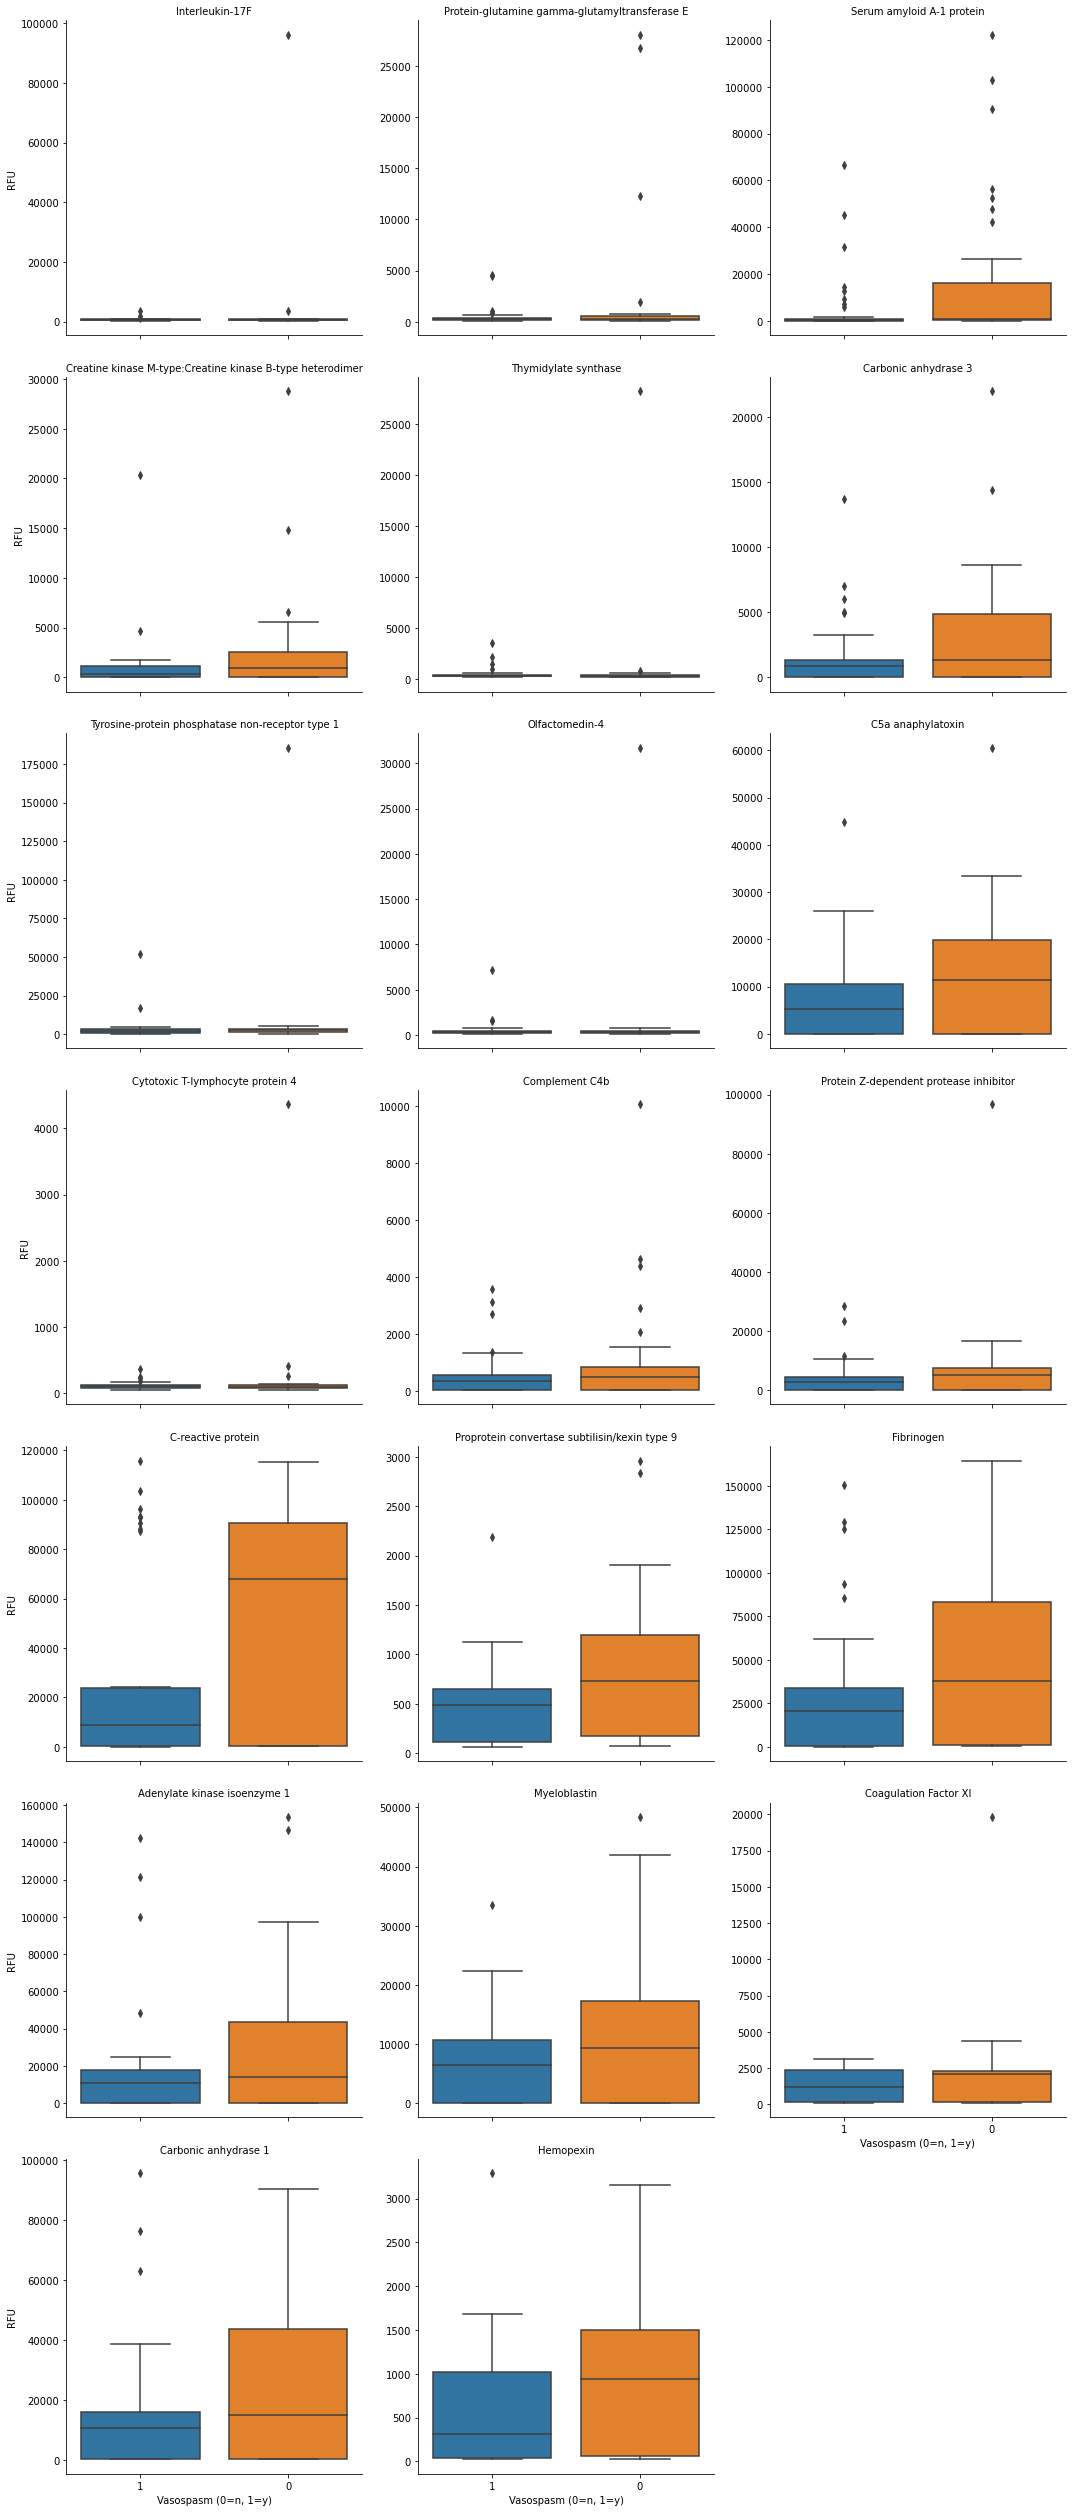

In [206]:
downReg_df = (
    filtered_transformed_data
        .pick_meta(axis=1, names=['TargetFullName'])
        .pick_on_meta(axis=1, name='TargetFullName', values=downReg_20)[downReg_20]
        .reset_index()
)


melted_downReg_df = pd.melt(downReg_df, value_vars=downReg_20, id_vars='Vasospasm (0=n, 1=y)', value_name='RFU')

downReg_p = sns.catplot(
    x='Vasospasm (0=n, 1=y)',
    y='RFU',
    col='TargetFullName',
    data=melted_downReg_df,
    kind='box',
    col_wrap=3,
    sharey=False
)
downReg_p.set_titles(row_template='{row_name}', col_template='{col_name}')
plt.show()

In [164]:
# Import the libraries that we need for this analysis
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import pearsonr
import statsmodels.api as sm
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [165]:
# Wrangle `clean_data` into a simpler form
logr_x_df = (
    clean_data
        .pick_meta(axis=1, names=['SeqId', 'TargetFullName'])
        .reset_index(drop=True)
)
logr_y_df = (
    clean_data.index.get_level_values('Vaso')
)

# Split the dataset into train and test, holding back 25 samples for testing
logr_x_train, logr_x_test, logr_y_train, logr_y_test = train_test_split(logr_x_df, logr_y_df, test_size=25, random_state=0)

In [166]:
logr_apt_perf = []
for seq_info in logr_x_train:
    x = sm.add_constant(logr_x_train[seq_info]) # Need to add the intercept term since sm.GLM does not automatically do it
    mod = sm.GLM(logr_y_train, x, family=sm.families.Binomial())
    res = mod.fit()
    logr_apt_perf.append(res.summary2().tables[1].loc[[seq_info]])

In [167]:
logr_df = pd.concat(logr_apt_perf).reset_index()
logr_df['SeqId'] = [x[0] for x in logr_df['index']]
logr_df['TargetFullName'] = [x[1] for x in logr_df['index']]
logr_df = logr_df.drop('index', axis=1)
logr_df = logr_df[['SeqId', 'TargetFullName', 'Coef.', 'Std.Err.', 'z', 'P>|z|', '[0.025', '0.975]']].set_index('SeqId')
logr_df_sorted = logr_df.sort_values('P>|z|')
HTML(logr_df_sorted.head(20).to_html()) # Need to use HTML here to display nicely for this README

,TargetFullName,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
SeqId,,,,,,,
4859-6,Bone morphogenetic protein receptor type-1A,0.003571,0.001375,2.597460,0.009392,0.000877,0.006266
3505-6,Lymphotoxin alpha1:beta2,0.010422,0.004048,2.574290,0.010045,0.002487,0.018356
14131-37,Ephrin-B2,0.000304,0.000118,2.571855,0.010116,0.000072,0.000536
5248-68,"Peptidyl-prolyl cis-trans isomerase F, mitochondrial",0.000372,0.000149,2.502103,0.012346,0.000081,0.000663
3813-3,Tyrosine-protein kinase Fyn,0.000298,0.000124,2.404803,0.016181,0.000055,0.000540
10336-3,E3 ubiquitin-protein ligase CHIP,0.002610,0.001120,2.331694,0.019717,0.000416,0.004805
3235-50,"WAP, Kazal, immunoglobulin, Kunitz and NTR domain-containing protein 2",0.000506,0.000223,2.265042,0.023510,0.000068,0.000943
4568-17,SLIT and NTRK-like protein 5,0.000804,0.000363,2.213077,0.026892,0.000092,0.001515
2171-12,HCE001796,0.000031,0.000014,2.184497,0.028926,0.000003,0.000058


In [168]:
logr_top_analytes = [(index, row['TargetFullName']) for index, row in logr_df_sorted.head(5).iterrows()] # Select the top 5 aptamers based on p-value
x = sm.add_constant(logr_x_train[logr_top_analytes])
logr_mod = sm.GLM(logr_y_train, x, family=sm.families.Binomial())
logr_res = logr_mod.fit()
logr_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   49
Model:                            GLM   Df Residuals:                       43
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.553
Date:                Tue, 13 Aug 2024   Deviance:                       47.105
Time:                        16:04:13   Pearson chi2:                     47.9
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3459
Covariance Type:            nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
const                                                                  -6.5137      2.058     -3.166      0.002     -10.546      -2.481
('4859-6', 'Bone morphogenetic protein receptor type-1A')               0.0018      0.002      1.161      0.246      -0.001       0.005
('3505-6', 'Lymphotoxin alpha1:beta2')                                  0.0006      0.006      0.094      0.925      -0.012       0.013
('14131-37', 'Ephrin-B2')                                               0.0003      0.000      2.147      0.032    2.49e-05       0.001
('5248-68', 'Peptidyl-prolyl cis-trans isomerase F, mitochondrial')   9.79e-05      0.000      0.750      0.453      -0.000       0.000
('3813-3', 'Tyrosine-protein kinase Fyn')                               0.0002      0.000      1.177      0.239      -0.000       0.001
=======================================================================================================================================
"""

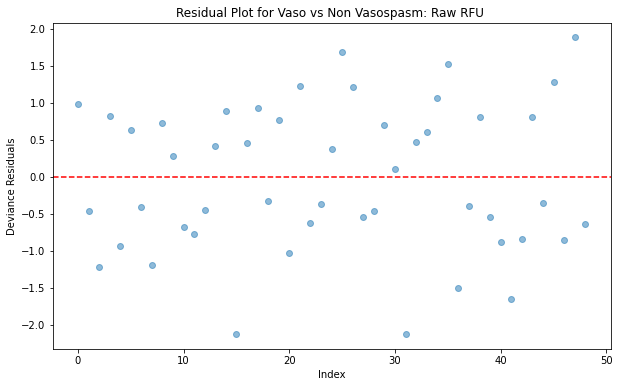

In [169]:
residuals = logr_res.resid_deviance

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Deviance Residuals')
plt.title('Residual Plot for Vaso vs Non Vasospasm: Raw RFU ')
plt.show()

##Vasospasm vs no Vasospasm - log10(RFU)

In [170]:
filtered_transformed_data = (
    redCell_adat
        .exclude_on_meta(axis=0, name='SampleMatrix', values=['Calibrator', 'QC'])                     
          # rm control samples
                                                     # log10-transform
)

filtered_transformed_data = (
    redCell_adat
        .exclude_on_meta(axis=0, name='redCell', values=['1'])                                         # log10-transform
        .pick_on_meta(axis=0, name='Vasospasm (0=n, 1=y)', values=['0', '1'])
        .apply(np.log10)
)
#HTML(filtered_transformed_data.iloc[:160, :1500].to_html())

In [171]:
clean_data = (
    filtered_transformed_data
        .insert_keyed_meta(                                          
            axis=0,
            key_meta_name='Vasospasm (0=n, 1=y)',
            inserted_meta_name='Vaso',
            values_dict={'1': 1, '0': 0}
        )
        #.apply(lambda x: x - x.mean(), axis=0)                       # center features
        #.apply(lambda x: x / x.std(), axis=0)                        # scale features
)


In [172]:
print(clean_data.index.to_frame()['Vaso'].value_counts())

1    38
0    36
Name: Vaso, dtype: int64


In [173]:
tt_g0 = clean_data.pick_on_meta(axis=0, name='Vaso', values=[0])
tt_g1 = clean_data.pick_on_meta(axis=0, name='Vaso', values=[1])

change = tt_g0.sub(tt_g1).div(tt_g1)
tt_res = ttest_ind(tt_g0, tt_g1)
t_tests = list(zip(clean_data.columns.get_level_values('TargetFullName'), tt_res.pvalue))
change_list = list(zip(clean_data.columns.get_level_values('TargetFullName'), change))
change_sorted = sorted(change_list, key=lambda x: x[1])

In [174]:
#Distribution
vaso0_mean_hist = np.histogram(tt_g0, bins=8)
vaso0_mean_hist

(array([   91,  1743,  6333, 18060, 13879,  4976,  1848,   482]),
 array([0.62324929, 1.25509298, 1.88693667, 2.51878037, 3.15062406,
        3.78246775, 4.41431144, 5.04615513, 5.67799883]))

In [175]:
g0_mean = np.mean(tt_g0)
g1_mean = np.mean(tt_g1)
fold_change = np.log2(g1_mean / g0_mean)

data5 = scipy.stats.norm.rvs(size=100000, loc=0, scale=1.5,random_state=123)
hist5 = np.histogram(fold_change, bins=8)
hist5

#change = tt_g0.sub(tt_g1).div(tt_g1)

#change_list = list(zip(clean_data.columns.get_level_values('TargetFullName'), change))
#change_sorted = sorted(change_list, key=lambda x: x[1])

/Users/kenny/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(array([  9,  50, 111, 157, 204, 334, 444,   8]),
 array([-0.26394138, -0.21613283, -0.16832428, -0.12051574, -0.07270719,
        -0.02489864,  0.0229099 ,  0.07071845,  0.118527  ]))

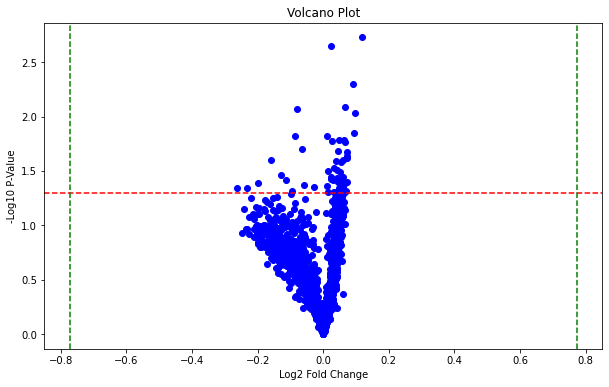

In [176]:
plt.figure(figsize=(10, 6))
plt.scatter(fold_change, np.negative(np.log10(tt_res.pvalue)), color='blue')

# Add horizontal line for p-value significance threshold (e.g., 0.05)
significance_threshold = 0.05
plt.axhline(-np.log10(significance_threshold), color='red', linestyle='--')

# Add vertical lines for fold change cutoffs (e.g., log2(1.5) ~ 0.585)
fold_change_threshold = 0.585
plt.axvline(np.log2(fold_change_threshold), color='green', linestyle='--')
plt.axvline(-np.log2(fold_change_threshold), color='green', linestyle='--')

# Labels and title
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-Value')
plt.title('Volcano Plot')

plt.show()
#plt.scatter(fold_change, tt_res.pvalue, color='blue')

In [194]:
fold_list_log10 = list(zip(clean_data.columns.get_level_values('TargetFullName'), fold_change))
fold_change_sorted_log10 = sorted(fold_list_log10, key=lambda x: x[1])

downReg_20_log10 = [name for name, down_change in fold_change_sorted_log10[:20]]
upReg_20_log10 = [name for name, up_change in fold_change_sorted_log10[1297:1317]]
downReg_20_log10

['Serum amyloid A-1 protein',
 'Interleukin-1 receptor-like 1',
 'GTP-binding nuclear protein Ran',
 'Adenylate kinase isoenzyme 1',
 'C-C motif chemokine 16',
 'Creatine kinase M-type:Creatine kinase B-type heterodimer',
 '6-phosphogluconate dehydrogenase, decarboxylating',
 'Transketolase',
 'Carbonic anhydrase 3',
 'C5a anaphylatoxin',
 'Fructose-bisphosphate aldolase A',
 'Carbohydrate sulfotransferase 15',
 'Alpha-enolase',
 'C-reactive protein',
 'Myeloblastin',
 'Angiotensinogen',
 'Hepcidin',
 'Plexin-B2',
 'Fibrinogen',
 'Tyrosine-protein kinase receptor Tie-1, soluble']

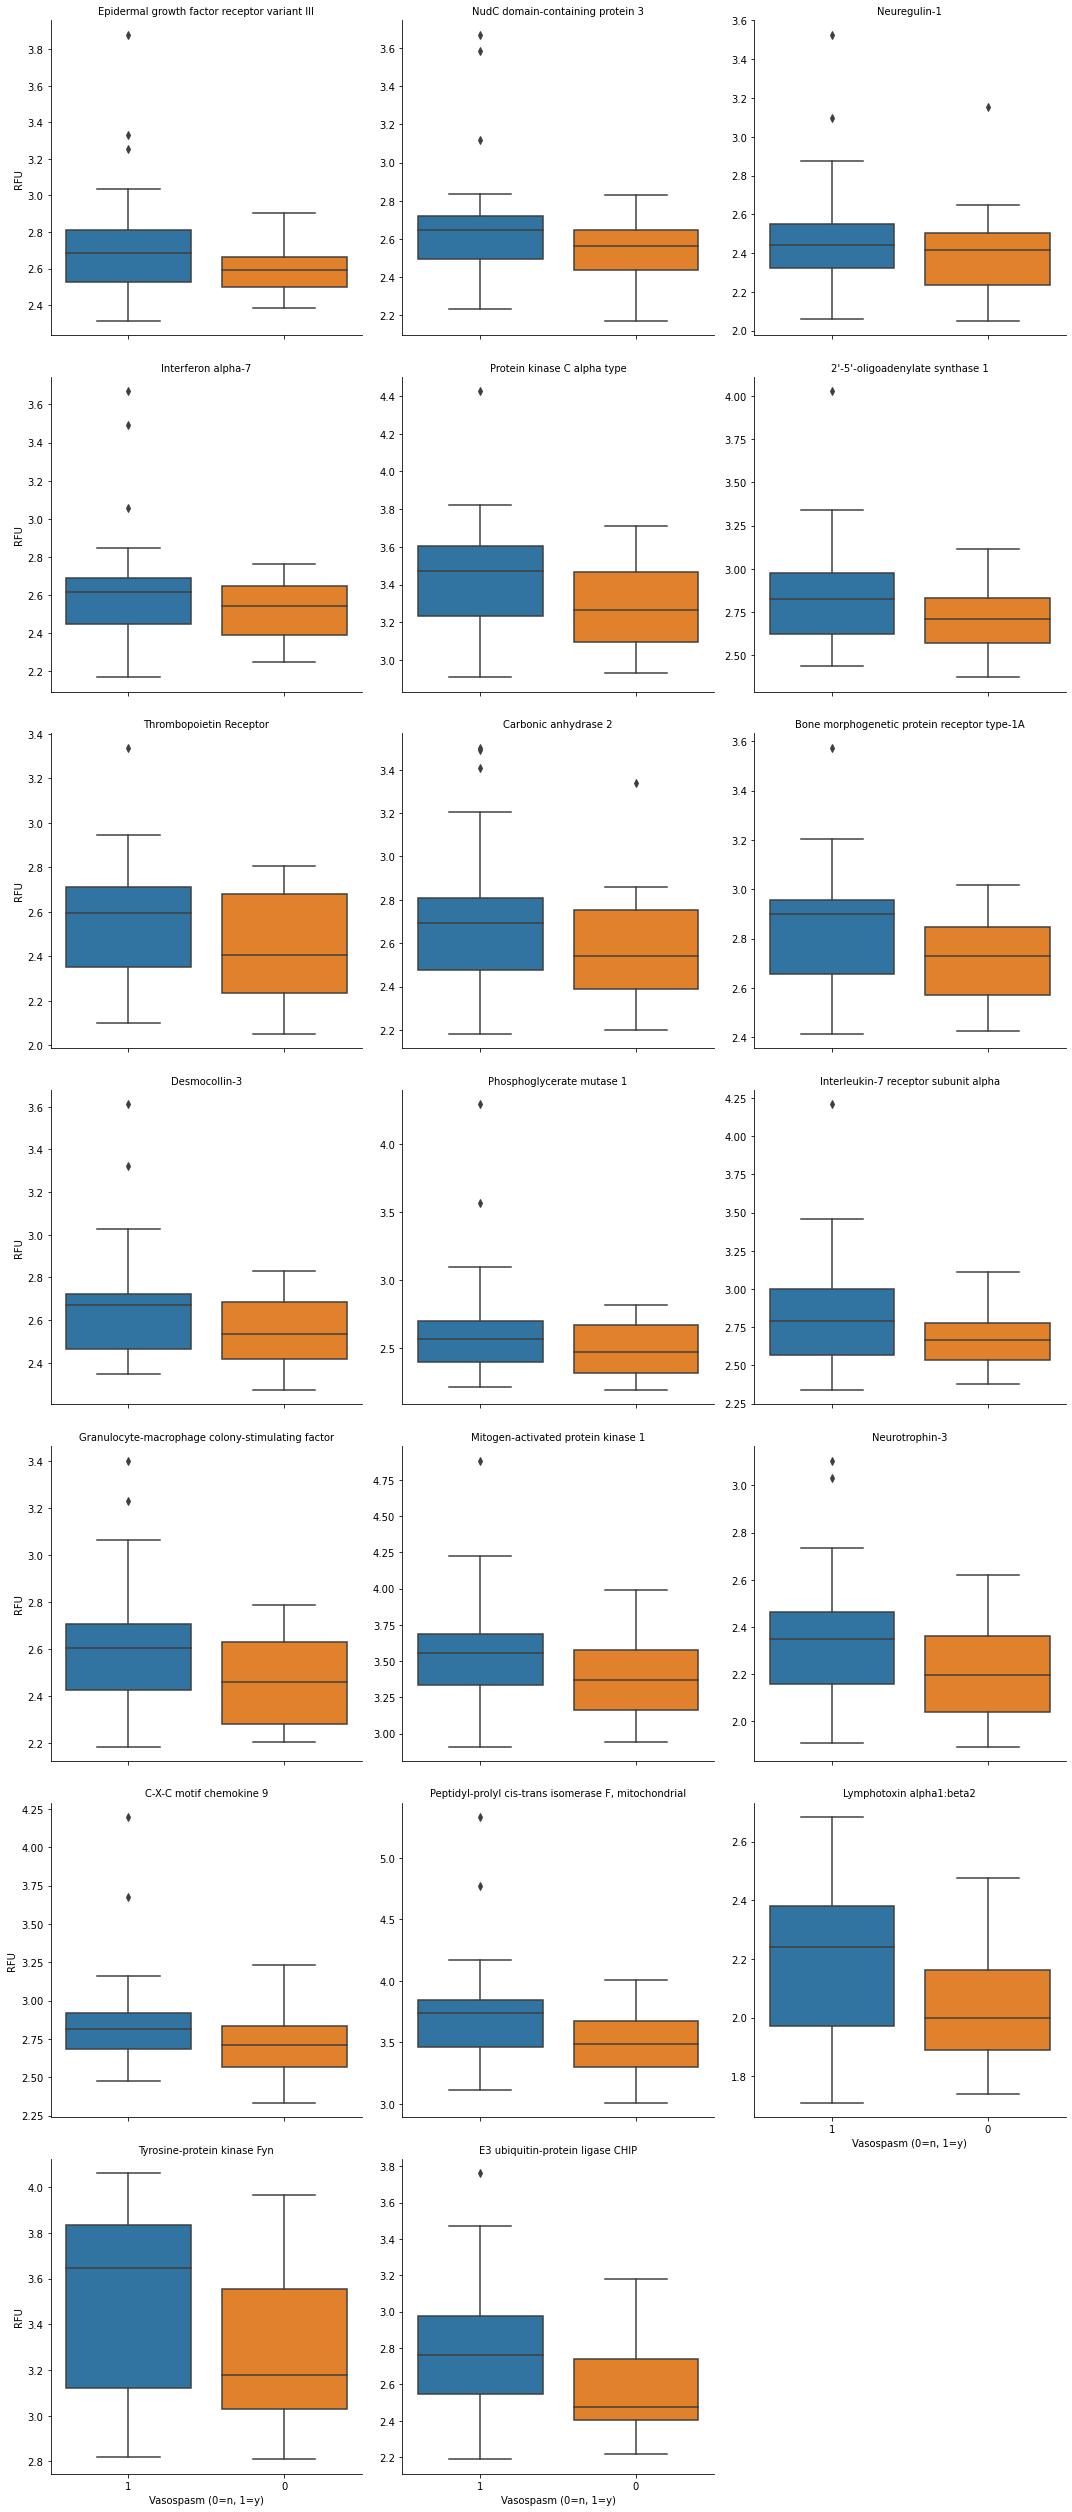

In [190]:
upReg_df_log10 = (
    filtered_transformed_data
        .pick_meta(axis=1, names=['TargetFullName'])
        .pick_on_meta(axis=1, name='TargetFullName', values=upReg_20_log10)[upReg_20_log10]
        .reset_index()
)

melted_upReg_df_log10 = pd.melt(upReg_df_log10, value_vars=upReg_20_log10, id_vars='Vasospasm (0=n, 1=y)', value_name='RFU')

upReg_p_log10 = sns.catplot(
    x='Vasospasm (0=n, 1=y)',
    y='RFU',
    col='TargetFullName',
    data=melted_upReg_df_log10,
    kind='box',
    col_wrap=3,
    sharey=False
)
upReg_p_log10.set_titles(row_template='{row_name}', col_template='{col_name}')
plt.show()

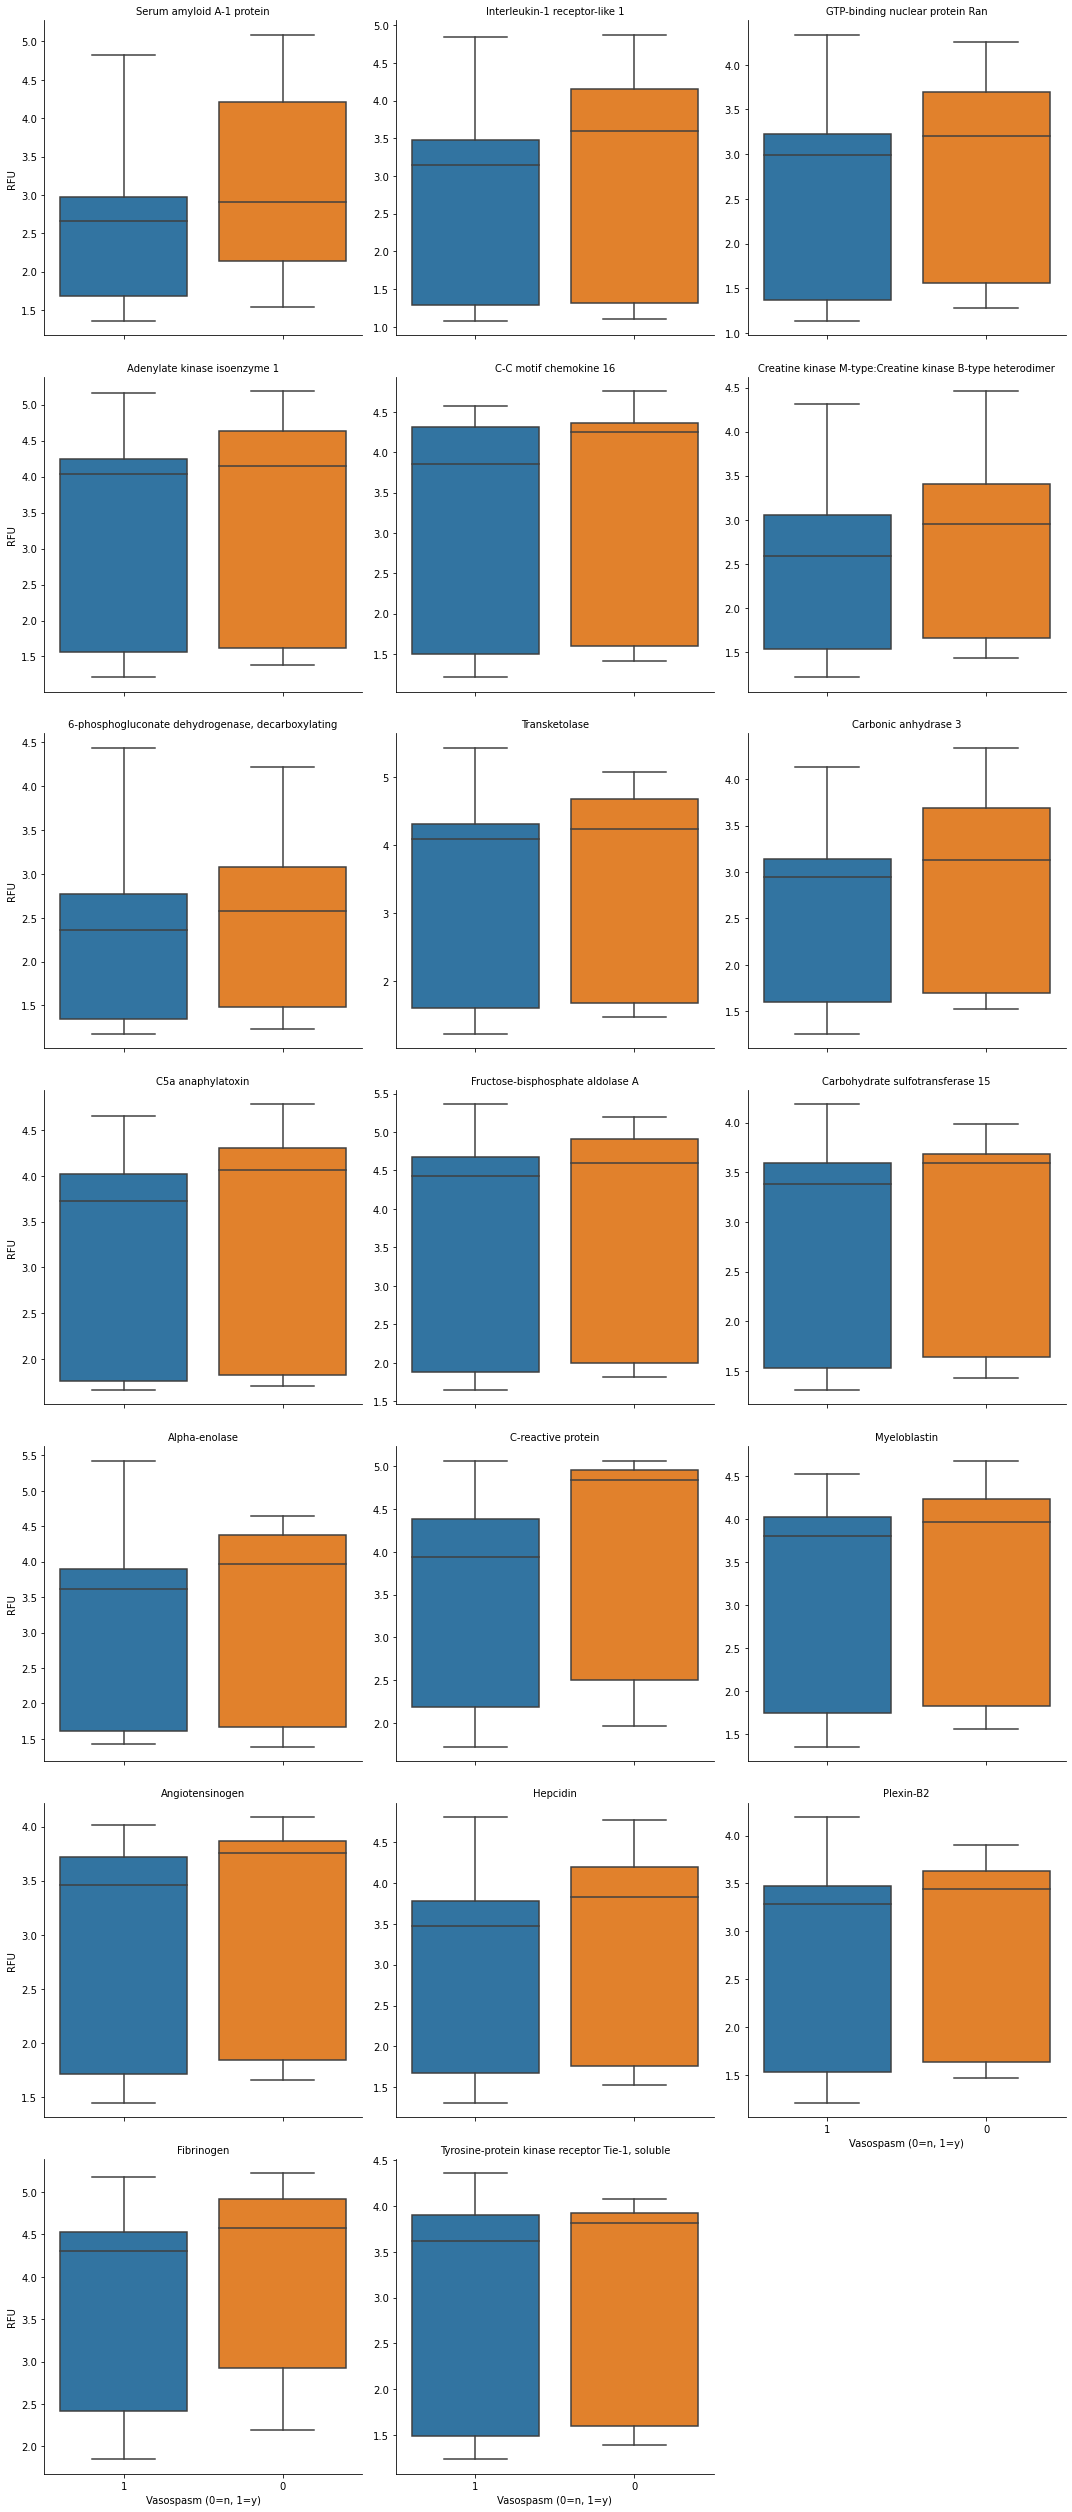

In [191]:
downReg_df_log10 = (
    filtered_transformed_data
        .pick_meta(axis=1, names=['TargetFullName'])
        .pick_on_meta(axis=1, name='TargetFullName', values=downReg_20_log10)[downReg_20_log10]
        .reset_index()
)


melted_downReg_df_log10 = pd.melt(downReg_df_log10, value_vars=downReg_20_log10, id_vars='Vasospasm (0=n, 1=y)', value_name='RFU')

downReg_p_log10 = sns.catplot(
    x='Vasospasm (0=n, 1=y)',
    y='RFU',
    col='TargetFullName',
    data=melted_downReg_df_log10,
    kind='box',
    col_wrap=3,
    sharey=False
)
downReg_p_log10.set_titles(row_template='{row_name}', col_template='{col_name}')
plt.show()

In [180]:
# Import the libraries that we need for this analysis
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import pearsonr
import statsmodels.api as sm
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [181]:
# Wrangle `clean_data` into a simpler form
logr_x_df = (
    clean_data
        .pick_meta(axis=1, names=['SeqId', 'TargetFullName'])
        .reset_index(drop=True)
)
logr_y_df = (
    clean_data.index.get_level_values('Vaso')
)

# Split the dataset into train and test, holding back 25 samples for testing
logr_x_train, logr_x_test, logr_y_train, logr_y_test = train_test_split(logr_x_df, logr_y_df, test_size=25, random_state=0)

In [182]:
logr_apt_perf = []
for seq_info in logr_x_train:
    x = sm.add_constant(logr_x_train[seq_info]) # Need to add the intercept term since sm.GLM does not automatically do it
    mod = sm.GLM(logr_y_train, x, family=sm.families.Binomial())
    res = mod.fit()
    logr_apt_perf.append(res.summary2().tables[1].loc[[seq_info]])

In [183]:
logr_df = pd.concat(logr_apt_perf).reset_index()
logr_df['SeqId'] = [x[0] for x in logr_df['index']]
logr_df['TargetFullName'] = [x[1] for x in logr_df['index']]
logr_df = logr_df.drop('index', axis=1)
logr_df = logr_df[['SeqId', 'TargetFullName', 'Coef.', 'Std.Err.', 'z', 'P>|z|', '[0.025', '0.975]']].set_index('SeqId')
logr_df_sorted = logr_df.sort_values('P>|z|')
HTML(logr_df_sorted.head(20).to_html()) # Need to use HTML here to display nicely for this README

,TargetFullName,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
SeqId,,,,,,,
5248-68,"Peptidyl-prolyl cis-trans isomerase F, mitochondrial",4.041968,1.422572,2.841310,0.004493,1.253778,6.830158
14131-37,Ephrin-B2,9.872231,3.689109,2.676048,0.007450,2.641711,17.102751
3813-3,Tyrosine-protein kinase Fyn,2.482291,0.936829,2.649674,0.008057,0.646141,4.318442
10336-3,E3 ubiquitin-protein ligase CHIP,3.231195,1.237592,2.610874,0.009031,0.805560,5.656830
4859-6,Bone morphogenetic protein receptor type-1A,4.815374,1.879145,2.562534,0.010391,1.132317,8.498431
3505-6,Lymphotoxin alpha1:beta2,3.584571,1.399804,2.560766,0.010444,0.841006,6.328137
4697-59,Granulocyte-macrophage colony-stimulating factor,4.266850,1.749755,2.438542,0.014747,0.837394,7.696307
4414-69,Pulmonary surfactant-associated protein D,-1.871185,0.769484,-2.431738,0.015027,-3.379347,-0.363023
3235-50,"WAP, Kazal, immunoglobulin, Kunitz and NTR domain-containing protein 2",4.251457,1.757625,2.418864,0.015569,0.806575,7.696338


In [184]:
logr_top_analytes = [(index, row['TargetFullName']) for index, row in logr_df_sorted.head(5).iterrows()] # Select the top 5 aptamers based on p-value
x = sm.add_constant(logr_x_train[logr_top_analytes])
logr_mod = sm.GLM(logr_y_train, x, family=sm.families.Binomial())
logr_res = logr_mod.fit()
logr_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   49
Model:                            GLM   Df Residuals:                       43
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.577
Date:                Tue, 13 Aug 2024   Deviance:                       47.154
Time:                        16:04:21   Pearson chi2:                     47.8
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3453
Covariance Type:            nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
const                                                                 -54.0464     18.714     -2.888      0.004     -90.726     -17.367
('5248-68', 'Peptidyl-prolyl cis-trans isomerase F, mitochondrial')     0.2569      1.946      0.132      0.895      -3.557       4.071
('14131-37', 'Ephrin-B2')                                               8.8229      4.367      2.020      0.043       0.263      17.383
('3813-3', 'Tyrosine-protein kinase Fyn')                               1.7768      1.466      1.212      0.225      -1.096       4.650
('10336-3', 'E3 ubiquitin-protein ligase CHIP')                         1.5574      1.529      1.019      0.308      -1.438       4.553
('4859-6', 'Bone morphogenetic protein receptor type-1A')               2.2989      2.246      1.024      0.306      -2.103       6.701
=======================================================================================================================================
"""

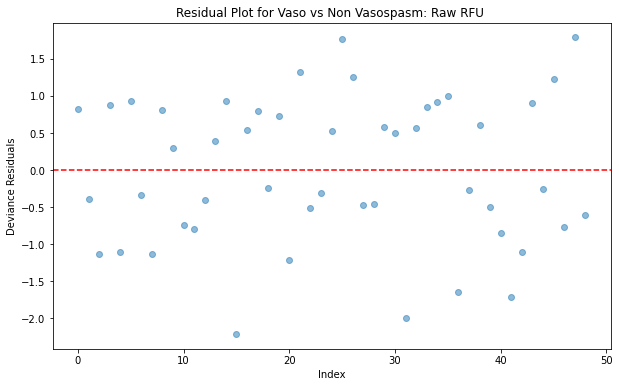

In [185]:
residuals = logr_res.resid_deviance

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Deviance Residuals')
plt.title('Residual Plot for Vaso vs Non Vasospasm: Raw RFU ')
plt.show()

In [230]:
t_tests_sorted = sorted(t_tests, key=lambda x: x[1])
tt_top_20_analytes = [name for name, p_value in t_tests_sorted[:20]]
tt_top_20_analytes
#print("p values of top 20: ", t_tests_sorted[:20])

['Ephrin-B2',
 'Proprotein convertase subtilisin/kexin type 9',
 'Tyrosine-protein kinase Fyn',
 'HCE001796',
 'Lymphotoxin alpha1:beta2',
 'E3 ubiquitin-protein ligase CHIP',
 'Complement component C9',
 'C5a anaphylatoxin',
 'Angiogenin',
 'Bone morphogenetic protein receptor type-1A',
 'Complement C5',
 'Coagulation Factor V',
 'SLIT and NTRK-like protein 5',
 'C-reactive protein',
 'Complement C5b-C6 complex',
 'HCE004359',
 'Endoplasmic reticulum resident protein 29',
 'Coagulation factor IX',
 'Angiopoietin-1 receptor, soluble',
 'Serum amyloid P-component']

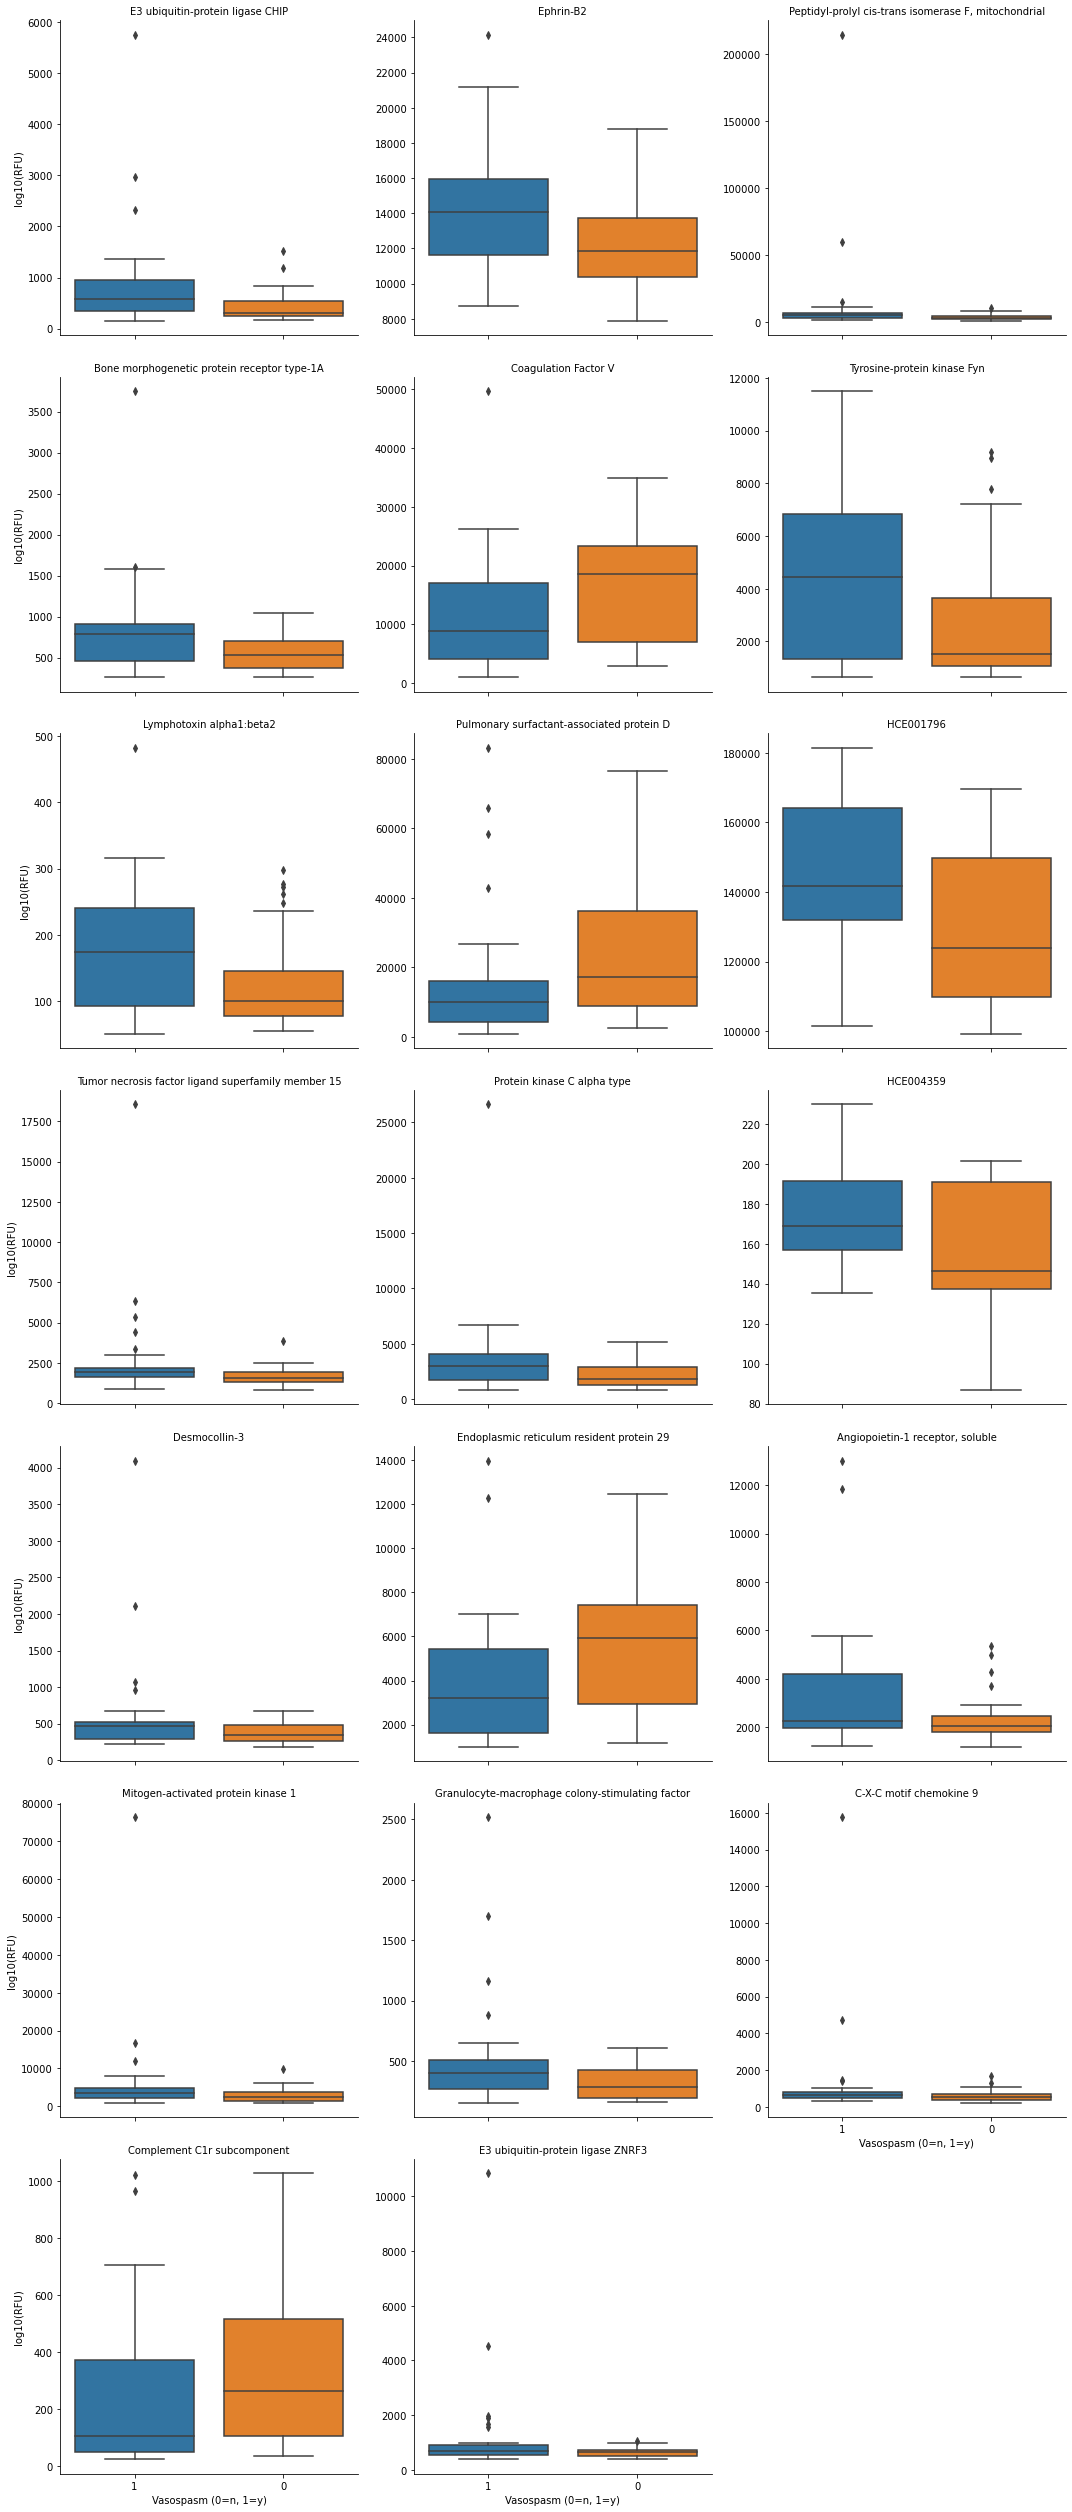

In [217]:
tt_df= (
    filtered_transformed_data
        .pick_meta(axis=1, names=['TargetFullName'])
        .pick_on_meta(axis=1, name='TargetFullName', values=tt_top_20_analytes)[tt_top_20_analytes]
        .reset_index()
)

tt_melted_df = pd.melt(tt_df, value_vars=tt_top_20_analytes, id_vars='Vasospasm (0=n, 1=y)', value_name='log10(RFU)')

tt_p = sns.catplot(
    x='Vasospasm (0=n, 1=y)',
    y='log10(RFU)',
    col='TargetFullName',
    data=tt_melted_df,
    kind='box',
    col_wrap=3,
    sharey=False
)
tt_p.set_titles(row_template='{row_name}', col_template='{col_name}')
plt.show()